In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as mcm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import PercentFormatter
from matplotlib.colors import LogNorm
from epiweeks import Week
from mpl_toolkits.axes_grid1 import make_axes_locatable
import baltic as bt
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
from countryinfo import CountryInfo
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd
from scipy.stats import gaussian_kde

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure X: Transmissions between San Diego and other Californian locations approximate transmissions within San Diego.
We plot the posterior distributions of transmissions between Baja California, Los Angeles, and two random subsets of San Diego to show that there are as many transmissions between connected locations as there are within a location.

Import the jumps from the discrete state analysis. This table is generated by running the `TreeMarkovJumpHistoryAnalyzer` on the posterior distribution of trees from the discrete-state reconstruction performed with BEAST.

In [2]:
jumps = pd.read_csv( "../data/2022-06-07_fixed_eponential_discrete_splitSD.Location.history.csv" )
jumps["date"] = jumps["time"].apply( dec_to_date )
jumps["date"] = jumps["date"].dt.normalize()
jumps.head()

,treeId,startLocation,endLocation,time,date
0,1000,Los Angeles,Rest of World,2020.976901,2020-12-23
1,1000,United States,Rest of World,2020.838857,2020-11-03
2,1000,United States,Rest of World,2020.939620,2020-12-09
3,1000,United States,Rest of World,2020.317902,2020-04-26
4,1000,Mexico,United States,2020.305844,2020-04-21


Remove directionality by sorting start and end location

In [3]:
jumps[["startLocation","endLocation"]] = np.sort( jumps[["startLocation", "endLocation"]], 1 )
jumps.head()

,treeId,startLocation,endLocation,time,date
0,1000,Los Angeles,Rest of World,2020.976901,2020-12-23
1,1000,Rest of World,United States,2020.838857,2020-11-03
2,1000,Rest of World,United States,2020.939620,2020-12-09
3,1000,Rest of World,United States,2020.317902,2020-04-26
4,1000,Mexico,United States,2020.305844,2020-04-21


Count number of jumps between each location pair for each tree in the posterior

In [4]:
jump_counts = jumps.groupby( ["treeId", "startLocation", "endLocation"] ).agg( count=("time", "count") )
jump_counts = jump_counts.reset_index()
jump_counts.head()

,treeId,startLocation,endLocation,count
0,1000,Baja California,Los Angeles,80
1,1000,Baja California,Mexico,75
2,1000,Baja California,Rest of World,3
3,1000,Baja California,San Diego A,81
4,1000,Baja California,San Diego B,60


Plot the distribution of jumps between the specified comparisons. H/t to @evogytis for the HPD plotting function.

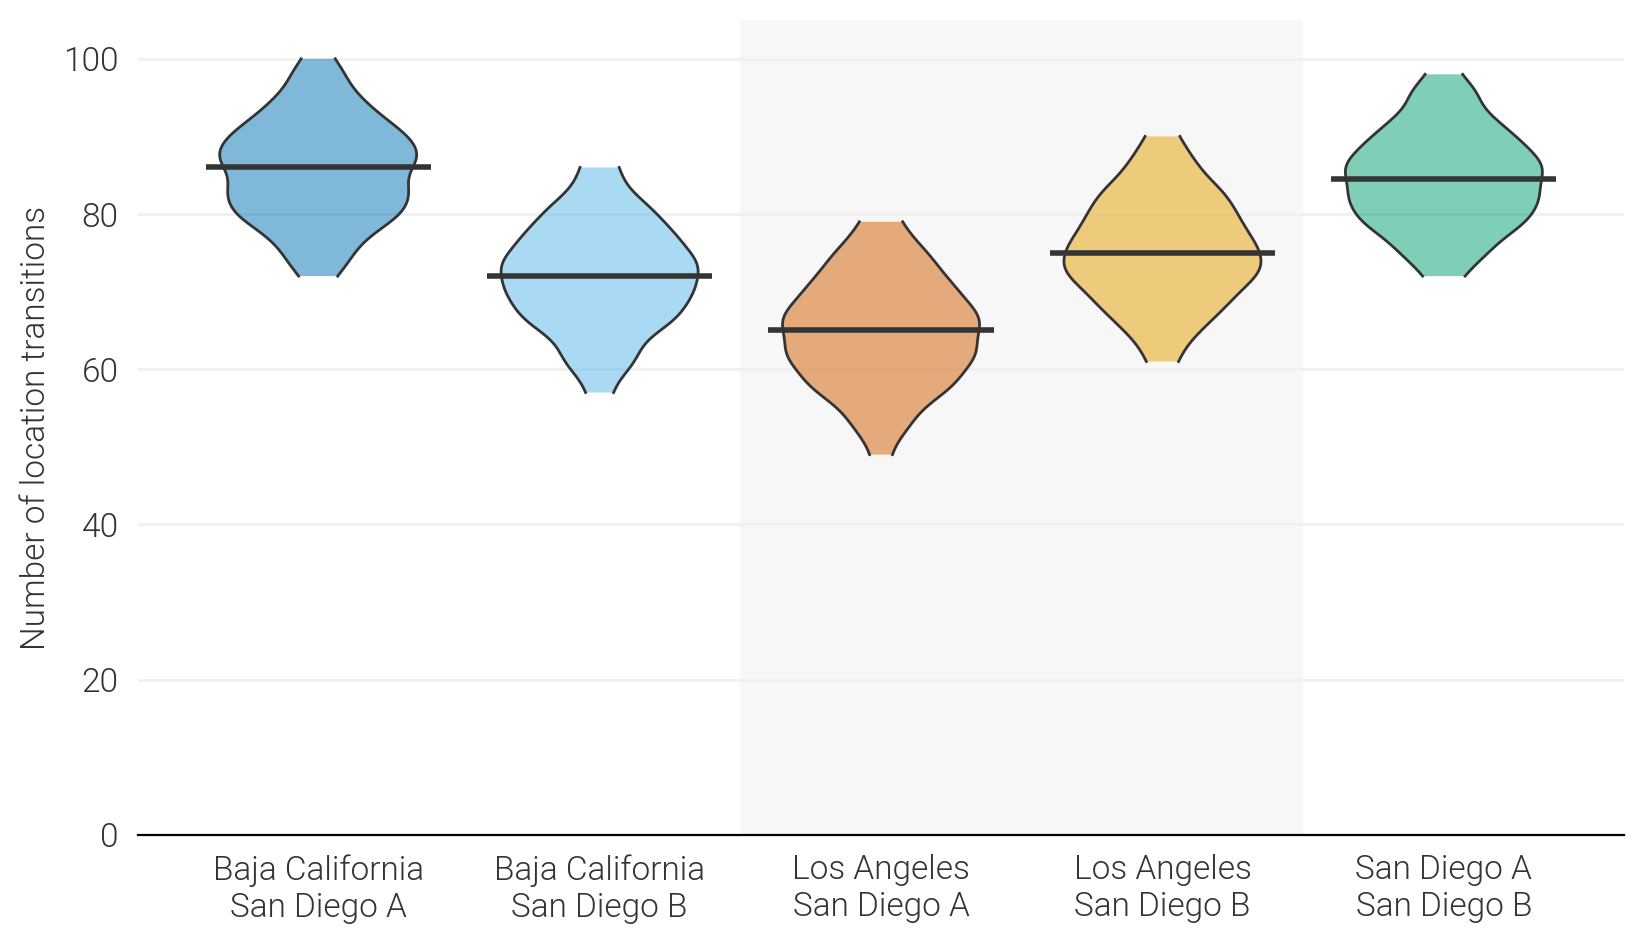

In [5]:
comparisons = [
    (jump_counts["startLocation"]=="Baja California")&(jump_counts["endLocation"]=="San Diego A"),
    (jump_counts["startLocation"]=="Baja California")&(jump_counts["endLocation"]=="San Diego B"),
    (jump_counts["startLocation"]=="Los Angeles")&(jump_counts["endLocation"]=="San Diego A"),
    (jump_counts["startLocation"]=="Los Angeles")&(jump_counts["endLocation"]=="San Diego B"),
    (jump_counts["startLocation"]=="San Diego A")&(jump_counts["endLocation"]=="San Diego B")
]
colors = [
    "#0072B2",
    "#56B4E9",
    "#D55E00",
    "#E69F00",
    "#009E73"
]

fig, ax = plt.subplots( dpi=200, figsize=(8.5,5) )
for i, query in enumerate( comparisons ):
    data = jump_counts.loc[query,"count"].to_numpy().ravel()
    data = data[~np.isnan(data)]
    data_median = np.median( data )

    hpdHi, hpdLo = hpd( data, 0.95 )
    x_grid = np.linspace( hpdLo, hpdHi, 101 )

    kde = gaussian_kde( data )
    y_grid = kde.evaluate( x_grid )
    y_grid = y_grid / y_grid.max() * 0.35

    ax.plot([i+y for y in y_grid],x_grid,color=COLOR,lw=1,zorder=100)
    ax.plot([i-y for y in y_grid],x_grid,color=COLOR,lw=1,zorder=100)

    ax.fill_betweenx(x_grid,[i-y for y in y_grid],[i+y for y in y_grid],facecolor=colors[i],edgecolor='none',alpha=0.5,zorder=100)
    ax.hlines( y=data_median, xmin=i-0.4, xmax=i+0.4, color=COLOR, linewidth=2, zorder=110 )
    
ax.set_xticks( range( len( comparisons ) ) )
ax.set_xticklabels( [
    "Baja California\nSan Diego A",
    "Baja California\nSan Diego B",
    "Los Angeles\nSan Diego A",
    "Los Angeles\nSan Diego B",
    "San Diego A\nSan Diego B"
] )

ax.axvspan( 1.5,3.5, color=COLOR, alpha=0.04, edgecolor=None, linewidth=0 )

basic_formatting( ax, ylabel="Number of location transitions", ylims=(0, 105) )
ax.tick_params( axis="x", which="both", rotation=0 )

plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_intra-vs-inter-jumps.pdf" )
plt.show()